In [51]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')

mesa docs
https://mesa.readthedocs.io/en/master/overview.html

paper
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.118.9072&rep=rep1&type=pdf

airport graph
https://ipython-books.github.io/142-drawing-flight-routes-with-networkx/

incar model
https://github.com/yjin8/carceral-contagion

In [52]:
import pandas as pd
import networkx as nx
#from IPython.display import Image

names = ('airline,airline_id,'
         'source,source_id,'
         'dest,dest_id,'
         'codeshare,stops,equipment').split(',')

routes = pd.read_csv(
    'https://github.com/ipython-books/'
    'cookbook-2nd-data/blob/master/'
    'routes.dat?raw=true',
    names=names,
    header=None)

routes.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [53]:
names = ('id,name,city,country,iata,icao,lat,lon,'
         'alt,timezone,dst,tz,type,source').split(',')

airports = pd.read_csv(
    'https://github.com/ipython-books/'
    'cookbook-2nd-data/blob/master/'
    'airports.dat?raw=true',
    header=None,
    names=names,
    index_col=4,
    na_values='\\N')

airports_us = airports[airports['country'] ==
                       'United States']

airports_us.head()

,id,name,city,country,icao,lat,lon,alt,timezone,dst,tz,type,source
iata,,,,,,,,,,,,,
BTI,3411,Barter Island LRRS Airport,Barter Island,United States,PABA,70.134003,-143.582001,2,-9.0,A,America/Anchorage,airport,OurAirports
LUR,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,PALU,68.875099,-166.110001,16,-9.0,A,America/Anchorage,airport,OurAirports
PIZ,3414,Point Lay LRRS Airport,Point Lay,United States,PPIZ,69.732903,-163.005005,22,-9.0,A,America/Anchorage,airport,OurAirports
ITO,3415,Hilo International Airport,Hilo,United States,PHTO,19.721399,-155.048004,38,-10.0,N,Pacific/Honolulu,airport,OurAirports
ORL,3416,Orlando Executive Airport,Orlando,United States,KORL,28.545500,-81.332901,113,-5.0,A,America/New_York,airport,OurAirports


In [54]:
routes_us = routes[
    routes['source'].isin(airports_us.index) &
    routes['dest'].isin(airports_us.index)]

routes_us.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
172,2O,146,ADQ,3531,KLN,7162,NaN,0,BNI
177,2O,146,KLN,7162,KYK,7161,NaN,0,BNI
260,3E,10739,BRL,5726,ORD,3830,NaN,0,CNC
261,3E,10739,BRL,5726,STL,3678,NaN,0,CNC
262,3E,10739,DEC,4042,ORD,3830,NaN,0,CNC


In [55]:
edges = routes_us[['source', 'dest']].values

g = nx.from_edgelist(edges)

In [56]:
from mesa                import Model, Agent
from mesa.space          import MultiGrid, NetworkGrid
from mesa.time           import RandomActivation
from mesa.datacollection import DataCollector
from random              import random, randrange, randint, choice
import pandas as pd

def compute_infection_rates(model):
    agents_infected = [agent.infected for agent in model.schedule.agents]
    num_infected = 0
    N = model.num_agents
    for infected in agents_infected:
        if infected == True: 
            num_infected += 1
    return num_infected/N

def compute_prev_infection_rates(model):
    agents_prev_infected = [agent.prev_infected for agent in model.schedule.agents]
    num_prev_infected = 0
    N = model.num_agents
    for prev_infected in agents_prev_infected:
        if prev_infected == True: 
            num_prev_infected += 1
    return num_prev_infected/N


class Person(Agent):
    """ An individual agent in the simulation
    sex -> "M" or "F"
    age_start -> The agent's age at the beginning of the 
        simulation, a value between 18 and 70
    current_age -> The agent's current age, depending on how 
        many months pass in the simulation
    month -> How many months have passed over the course
        of the simulation
    prev_incarcerated -> True or False depending on if
        the agent was formerly imprisoned
    incarcerated -> True or False depending on if the agent
        is imprisoned in the current iteration
    """
    def __init__(self, unique_id, model, infection_prob, removed_prob = 0, virality = 0.5, resilience = 0.1):
        self.model = model
        self.infection_prob = infection_prob
        self.virality = virality
        self.resilience = resilience
        self.unique_id = unique_id
        
        self.prev_infected = decision(removed_prob)
        if ~self.prev_infected:
            self.infected = decision(self.infection_prob / (1 - removed_prob))
        else:
            self.infected = False

        self.year = 0

    def move(self):
        """Agent changes position in grid"""
        possible_steps = self.model.grid.get_neighbors(
            self.pos)
        new_position = choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    #Determines probability of infection being transmitted
    #from one agent to another
    def transmit(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        #determies number of agents in the same space

        if len(cellmates) > 1: #if there's more than 1 agent in cell
            for other in cellmates:
                if other.infected == True and self.prev_infected == False:
                    self.infected = decision(self.virality)

                else:
                    pass

       
    def step(self):
        
        self.year += 1/52
        self.move()
        
        if self.infected and decision(self.resilience):
            self.infected = False
            self.prev_infected = True
            
        if self.infected == False:
            self.transmit()
            
        else:
            pass


class EpiModel(Model):
    """ 
    An agent-based epidemiological model of mass incarceration and     
    its resultant racial disparities in the United States,             
    programmed in Python 3.6 using Mesa by Yuchen Jin and Adam Rahman. 
    We instantiate separate classes of agents and models and allow 
    the simulation to step through units of months, with agents moving
    in between cells in a grid and interacting with one another. People
    'transmit' the likeliness of being incarcerated through risk behaviors
    and psychological conditioning, hence spreading the risk of being imprisoned.
    """
    def __init__(self, N, network, infection_prob, removed_prob = 0, virality = 0.5, resilience = 0.1):
        self.running = True
        self.num_agents = N
        self.grid = NetworkGrid(network)
        self.schedule = RandomActivation(self)
        self.num_incarcerated = 0

        # Create agents
        for i in range(self.num_agents):

            a = Person(i, self, infection_prob, removed_prob, virality, resilience)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = choice(list(g.nodes))
            self.grid.place_agent(a, x)

        self.datacollector = DataCollector(
           model_reporters = {"Infection Rates": compute_infection_rates, "Removed Rates": compute_prev_infection_rates},
           agent_reporters = {"Infected:": lambda a : a.infected})
        
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

def decision(probability):
    ''' Given a probability p, P(True) = p, 
    P(False) = 1-p '''
    return random() < probability

In [57]:
## Hybrid Model
import time

def hybrid_model(N, infection_prob, virality, resilience, threshold, tot_iter):
    
    avg_cellmates = N / len(list(g.nodes))
    model = EpiModel(N, g, infection_prob, 0, virality, resilience)
    model_df = pd.DataFrame(columns=['Infection Rates', 'Removed Rates', 'SIR model'])
    
    alpha = virality/2
    beta = resilience

    n_iter = 0
    start = time.time()
    while n_iter < tot_iter:
        iteration_df = model.datacollector.get_model_vars_dataframe().iloc[-1,:]
        model_df = model_df.append(iteration_df, ignore_index=True)

        I = model_df['Infection Rates'].iloc[-1]
        R = model_df['Removed Rates'].iloc[-1]
        S = 1 - I - R

        while I > threshold and n_iter < tot_iter:
            S -= alpha*I*S
            R += beta*I
            I = 1 - R - S
            #Snew = S - alpha*I*S
            #Inew = I + alpha*I*S - beta*I
            #Rnew = R + beta*I
            #S = Snew
            #I = Inew
            #R = Rnew
            model_df = model_df.append({'Infection Rates': I, 
                        'Removed Rates':R,
                        'SIR model':True,
                        }, ignore_index=True, sort=False)
            n_iter += 1
        
        switch = 0    
        if model_df['SIR model'].iloc[-1]==True:
            switch_start = time.time()
            model = EpiModel(N, g, I, R, virality, resilience)
            switch_end = time.time()
            switch = switch_end - switch_start

        model.step()
        n_iter += 1

    stop = time.time()
    runtime = stop - start - switch
    return model_df, runtime

In [58]:
# Standard Model

def standard_model(N, infection_prob, virality, resilience, tot_iter):
    
    model = EpiModel(N, g, infection_prob, 0, virality, resilience)

    start = time.time()
    for i in range(tot_iter):
        model.step()

    model_df = model.datacollector.get_model_vars_dataframe()      

    stop = time.time()
    runtime = stop - start
    return model_df, runtime

In [73]:
## Define the model parameters
N = 10000
n_iter = 100

# Initial probabilities
infection_prob = 0.05

# Transmission and healing rates
virality = 0.4 # Probability of infection
resilience = 0.01 # Probability of recovery at easch timestep

# Parameters for the differential model and switching threshold
threshold = 0.5

In [74]:
# Run models
hybrid, runtime_h = hybrid_model(N, infection_prob, virality, resilience, threshold, n_iter)
standard, runtime_s = standard_model(N, infection_prob, virality, resilience, n_iter)

print(runtime_h, runtime_s)

22.06624984741211 22.663856029510498


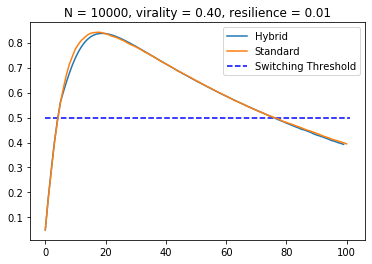

In [75]:
import matplotlib.pyplot as plt

plt.plot(hybrid['Infection Rates'], label='Hybrid')
plt.plot(standard['Infection Rates'], label='Standard')
plt.hlines(threshold, 0, len(standard), colors='b', linestyles='dashed', label='Switching Threshold')
plt.title('N = %d, virality = %.2f, resilience = %.2f' % (N,virality,resilience))
plt.legend()

In [76]:
print(len(list(g.nodes)))
print(N / len(list(g.nodes))-1)

546
17.315018315018314


In [77]:
(1-(1-virality)**(N / len(list(g.nodes))-1))/(N / len(list(g.nodes))-1)

0.05774500926819063

In [78]:
import scipy as sp

A = nx.adjacency_matrix(g)
n = sp.sparse.linalg.norm(A) / N
n

0.007457881736793633

$${\frac  {dS}{dt}}=-\alpha IS$$

$${\frac {dI}{dt}}={\alpha IS}-\beta I$$

$${\frac {dR}{dt}}=\beta I$$